# Coin Grade Classifier - Dual-Image ResNet Fine-Tuning

Fine-tunes **pretrained ResNet-50** to classify coin grades using **both obverse and reverse** images.

## Key Features:
- 🪙 **Dual-Image Input**: Both sides of each coin
- 🔍 **Full Resolution**: 1000x1000 pixels
- 🎯 **Transfer Learning**: ResNet-50 pretrained on ImageNet
- 🔄 **Feature Fusion**: Combines information from both sides
- 🧊 **Progressive Unfreezing**: Frozen → Fine-tuned backbone

## Training Strategy:
1. **Phase 1** (Epochs 1-20): Freeze ResNet backbone, train only classifier
2. **Phase 2** (Epochs 21-50): Unfreeze all layers, fine-tune end-to-end

## 1. Setup and Imports

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import os
import json
from pathlib import Path
from PIL import Image
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS (Apple Silicon) available: True")

PyTorch version: 2.6.0
CUDA available: False
MPS (Apple Silicon) available: True


## 2. Configuration

Adjust these settings:
- **DATA_DIR**: Choose 'Proof' or 'Circulation'
- **FREEZE_BACKBONE**: True to freeze ResNet initially
- **UNFREEZE_EPOCH**: When to start fine-tuning (20)

In [16]:
# Paths
DATA_DIR = 'davidlawrence_dataset/Circulation'
OUTPUT_DIR = 'models'
LOG_DIR = 'runs/resnet_dual_' + datetime.now().strftime('%Y%m%d_%H%M%S')

# Model hyperparameters
IMAGE_SIZE = 1000
BATCH_SIZE = 2
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
FREEZE_BACKBONE = True
UNFREEZE_EPOCH = 20

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Data: {DATA_DIR}")

Device: mps
Image size: 1000x1000
Batch size: 2
Data: davidlawrence_dataset/Circulation


## 3. Dataset Class

In [17]:
class DualCoinDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        grade_folders = sorted([d for d in self.data_dir.iterdir() if d.is_dir()])
        
        for idx, grade_folder in enumerate(grade_folders):
            grade_name = grade_folder.name
            self.class_to_idx[grade_name] = idx
            self.idx_to_class[idx] = grade_name
            
            obverse_dir = grade_folder / 'obverse'
            reverse_dir = grade_folder / 'reverse'
            
            if not obverse_dir.exists() or not reverse_dir.exists():
                continue
            
            obverse_images = sorted([f for f in obverse_dir.glob('*.jpg') if f.is_file()])
            
            for obverse_img in obverse_images:
                reverse_img = reverse_dir / obverse_img.name
                if reverse_img.exists():
                    self.samples.append({
                        'obverse': obverse_img,
                        'reverse': reverse_img,
                        'label': idx,
                        'grade': grade_name
                    })
        
        # 80/20 split
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        n_train = int(0.8 * len(self.samples))
        
        if split == 'train':
            indices = indices[:n_train]
        else:
            indices = indices[n_train:]
        
        self.samples = [self.samples[i] for i in indices]
        
        print(f"{split.upper()}: {len(self.samples)} samples, {len(self.class_to_idx)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        obverse = Image.open(sample['obverse']).convert('RGB')
        reverse = Image.open(sample['reverse']).convert('RGB')
        
        if self.transform:
            obverse = self.transform(obverse)
            reverse = self.transform(reverse)
        
        return obverse, reverse, sample['label']

print("✓ Dataset class defined")

✓ Dataset class defined


## 4. Data Transforms

ImageNet normalization for pretrained ResNet.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(degrees=5, fill=(255, 255, 255)),
    transforms.ToTensor(),
        transforms.RandomAffine(
        degrees=0,              # rotation already handled
        translate=(0.03, 0.03), # small shifts in x/y
        scale=(0.95, 1.05),     # small zoom in/out
        fill=(255, 255, 255)
    ),

    # Photometric: tiny lighting/contrast wiggles
    transforms.ColorJitter(
        brightness=0.05,
        contrast=0.05,
        saturation=0.05,
        hue=0.01
    ),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Transforms configured")

✓ Transforms configured


## 5. Visualize Preprocessed Images

**Before training, let's see what the preprocessed images look like!**

This shows how transforms affect the images:
- Resizing to 1000x1000
- ImageNet normalization
- Random augmentations (for training)

TRAIN: 2944 samples, 22 classes


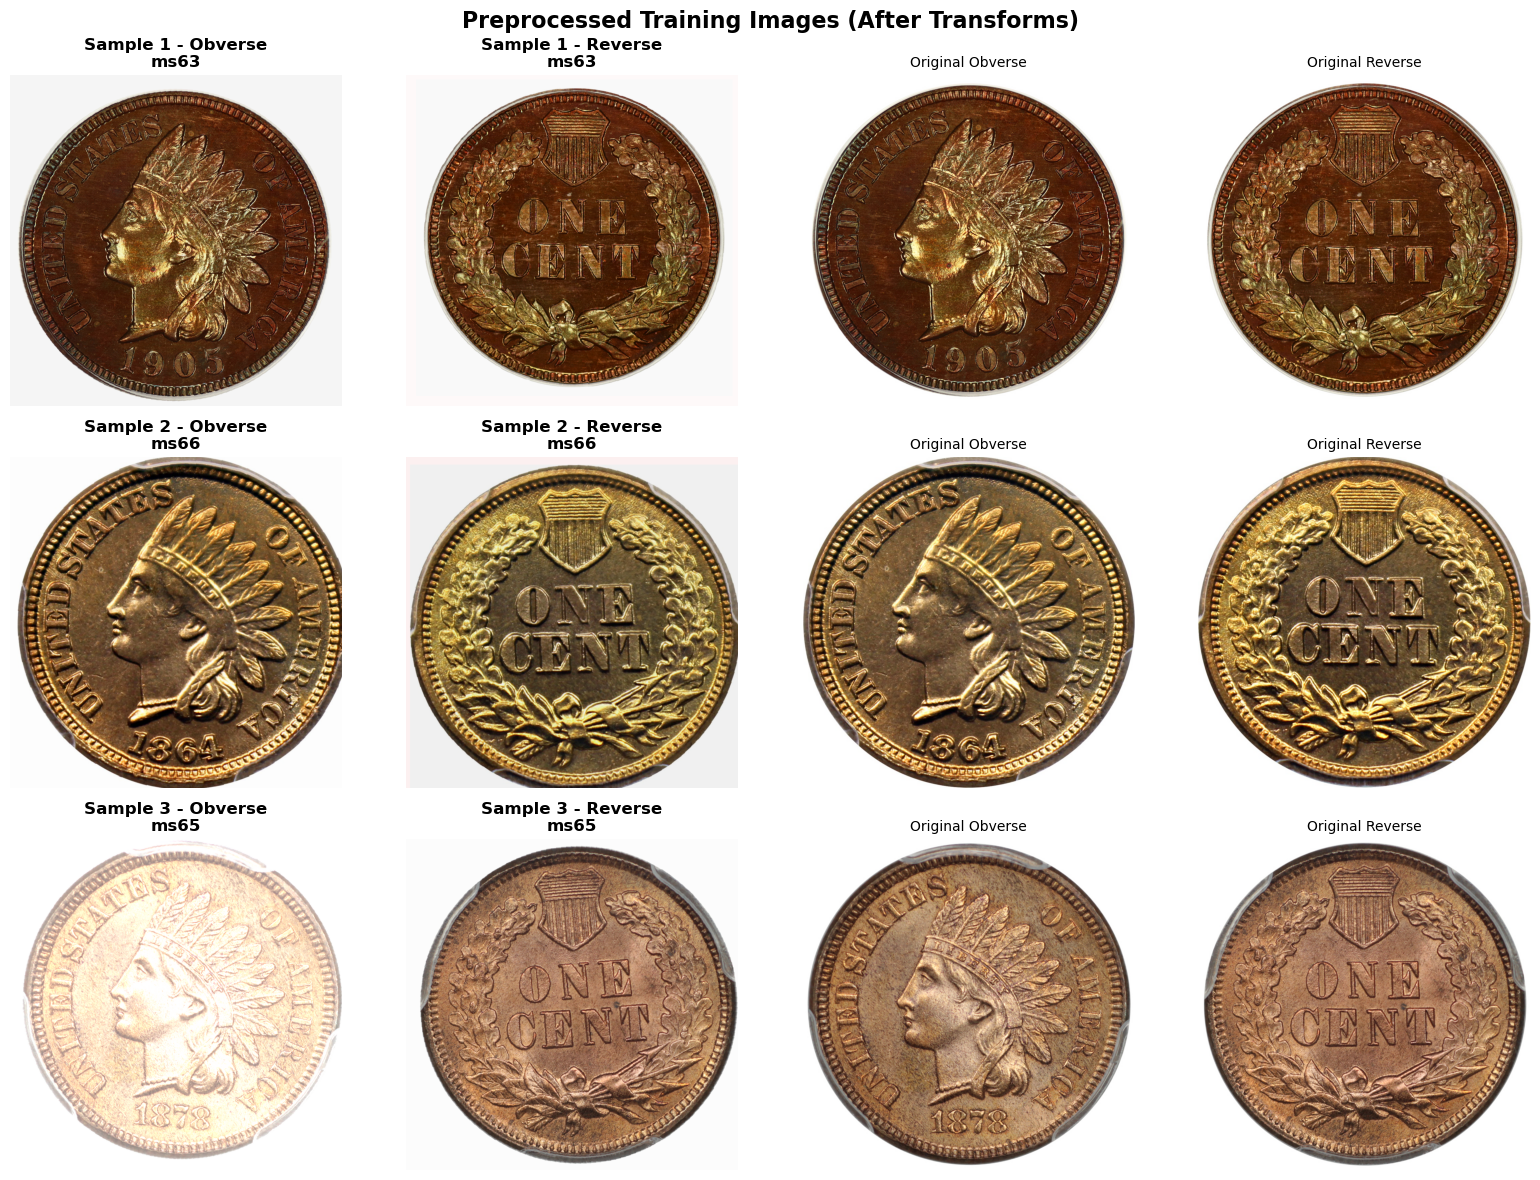


✓ Visualization complete!
  Left columns: Preprocessed (normalized)
  Right columns: Original (for comparison)


In [24]:
# Helper function to denormalize images for display
def denormalize(tensor):
    '''Convert normalized tensor back to displayable image'''
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

# Create a temporary dataset to visualize
viz_dataset = DualCoinDataset(DATA_DIR, split='train', transform=train_transform)

# Get a few samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Preprocessed Training Images (After Transforms)', fontsize=16, fontweight='bold')

for i in range(3):
    if i >= len(viz_dataset):
        break
    
    obverse, reverse, label = viz_dataset[i]
    grade = viz_dataset.idx_to_class[label]
    
    # Denormalize for display
    obverse_img = denormalize(obverse)
    reverse_img = denormalize(reverse)
    
    # Obverse
    axes[i, 0].imshow(obverse_img.permute(1, 2, 0).numpy())
    axes[i, 0].set_title(f'Sample {i+1} - Obverse\n{grade}', fontweight='bold')
    axes[i, 0].axis('off')
    
    # Reverse
    axes[i, 1].imshow(reverse_img.permute(1, 2, 0).numpy())
    axes[i, 1].set_title(f'Sample {i+1} - Reverse\n{grade}', fontweight='bold')
    axes[i, 1].axis('off')
    
    # Show original (without transforms) for comparison
    original_obv = Image.open(viz_dataset.samples[i]['obverse']).convert('RGB')
    original_rev = Image.open(viz_dataset.samples[i]['reverse']).convert('RGB')
    
    axes[i, 2].imshow(original_obv)
    axes[i, 2].set_title(f'Original Obverse', fontsize=10)
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(original_rev)
    axes[i, 3].set_title(f'Original Reverse', fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")
print(f"  Left columns: Preprocessed (normalized)")
print(f"  Right columns: Original (for comparison)")

## 6. Create Datasets and DataLoaders

In [ ]:
train_dataset = DualCoinDataset(DATA_DIR, split='train', transform=train_transform)
test_dataset = DualCoinDataset(DATA_DIR, split='test', transform=val_transform)
val_dataset = test_dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = test_loader

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test/Val batches: {len(test_loader)} (same set)")

## 7. Dual ResNet Model

In [ ]:
class DualResNetClassifier(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super(DualResNetClassifier, self).__init__()
        
        weights = ResNet50_Weights.IMAGENET1K_V2
        obverse_resnet = resnet50(weights=weights)
        reverse_resnet = resnet50(weights=weights)
        
        self.obverse_encoder = nn.Sequential(*list(obverse_resnet.children())[:-1])
        self.reverse_encoder = nn.Sequential(*list(reverse_resnet.children())[:-1])
        
        if freeze_backbone:
            for param in self.obverse_encoder.parameters():
                param.requires_grad = False
            for param in self.reverse_encoder.parameters():
                param.requires_grad = False
        
        self.feature_dim = 2048
        
        self.fusion = nn.Sequential(
            nn.Linear(self.feature_dim * 2, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def unfreeze_backbone(self):
        for param in self.obverse_encoder.parameters():
            param.requires_grad = True
        for param in self.reverse_encoder.parameters():
            param.requires_grad = True
    
    def forward(self, obverse, reverse):
        obverse_feat = self.obverse_encoder(obverse).view(obverse.size(0), -1)
        reverse_feat = self.reverse_encoder(reverse).view(reverse.size(0), -1)
        combined = torch.cat([obverse_feat, reverse_feat], dim=1)
        fused = self.fusion(combined)
        return self.classifier(fused)

num_classes = len(train_dataset.class_to_idx)
model = DualResNetClassifier(num_classes=num_classes, freeze_backbone=FREEZE_BACKBONE)
model = model.to(DEVICE)

print(f"\nModel: {num_classes} classes")
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

## 8. Training Setup

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                  patience=5, verbose=True)
writer = SummaryWriter(LOG_DIR)

print("✓ Training setup complete")

## 9. Training and Validation Functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for obverse, reverse, labels in pbar:
        obverse, reverse, labels = obverse.to(device), reverse.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(obverse, reverse)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * obverse.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / total, 100 * correct / total

def validate(model, loader, criterion, device, split='Val'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=f'{split}')
        for obverse, reverse, labels in pbar:
            obverse, reverse, labels = obverse.to(device), reverse.to(device), labels.to(device)
            outputs = model(obverse, reverse)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * obverse.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / total, 100 * correct / total

print("✓ Training functions defined")

## 10. Main Training Loop

**Run this cell to start training!**

In [ ]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = os.path.join(OUTPUT_DIR, 'coin_resnet_dual_best.pth')

print("="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Unfreeze backbone after specified epoch
    if FREEZE_BACKBONE and epoch == UNFREEZE_EPOCH:
        print(f"\n🔓 Unfreezing backbone at epoch {epoch+1}")
        model.unfreeze_backbone()
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE/10, weight_decay=0.01)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    print(f"\nEpoch {epoch+1}: Train={train_acc:.2f}%, Val={val_acc:.2f}%, LR={current_lr:.6f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx,
            'idx_to_class': train_dataset.idx_to_class
        }, best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
writer.close()

## 11. Plot Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
if FREEZE_BACKBONE:
    ax1.axvline(x=UNFREEZE_EPOCH, color='red', linestyle='--', alpha=0.5, label='Unfreeze')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
if FREEZE_BACKBONE:
    ax2.axvline(x=UNFREEZE_EPOCH, color='red', linestyle='--', alpha=0.5, label='Unfreeze')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history_resnet.png'), dpi=300)
plt.show()

## 12. Final Test Evaluation

In [ ]:
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = validate(model, test_loader, criterion, DEVICE, split='Test')

print(f"\n{'='*60}")
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*60)

## 13. Save Results

In [ ]:
with open(os.path.join(OUTPUT_DIR, 'history_resnet.json'), 'w') as f:
    json.dump(history, f, indent=2)

config = {
    'architecture': 'DualResNetClassifier (ResNet-50)',
    'image_size': IMAGE_SIZE,
    'best_val_acc': best_val_acc,
    'test_acc': test_acc
}

with open(os.path.join(OUTPUT_DIR, 'config_resnet.json'), 'w') as f:
    json.dump(config, f, indent=2)

print("✓ Results saved!")
print(f"  Best Val Acc: {best_val_acc:.2f}%")
print(f"  Test Acc: {test_acc:.2f}%")